### Import Libraries

In [1]:
import cv2
import numpy as np
from scipy import ndimage
from skimage import color
from skimage import feature
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from extcolors import extract_from_path
import pandas as pd
import os
from matplotlib import pyplot as plt


After doing a for loop on the whole dataset (Melanoma =1  VS. Not Melanoma = 0) applying the processing steps and extractiong the features, we save the outputs to a dataframe consists of 6020 rows × 6 columns. 

In [ ]:
folder_path = 'DermMel\\train_sep\\NotMelanoma'


for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        # Construct the full path to the image
        image_path = os.path.join(folder_path, filename)

        # Read the image
        image = cv2.imread(image_path)

        # Ensure the image is not empty
        if image is not None:
            # Preprocess the image (replace these functions with your actual preprocessing steps)
            clahe_image = apply_clahe(image)
            gaussian_filtered_image = apply_gaussian_filter(clahe_image)
            median_filtered_image = apply_median_filter(gaussian_filtered_image)

            # Segmentation
            kmeans_segmented_image = apply_kmeans(median_filtered_image)
            canny_edges = apply_canny(kmeans_segmented_image)
            adaptive_threshold_image = apply_adaptive_threshold(kmeans_segmented_image)

            # Post-processing
            swapped_image = swap_colors(adaptive_threshold_image)
            processed_image = remove_isolated_pixels(swapped_image)

            # Feature extraction
            asymmetry_score = calculate_asymmetry(processed_image)
            area, perimeter = calculate_area_and_perimeter(processed_image)
            circularity = calculate_circularity(area, perimeter)
            number_of_colors = extract_number_of_colors(image_path)

            # Append the results to the DataFrame
            df = df.append({
                'Image Path': image_path,
                'Asymmetry Score': asymmetry_score,
                'Area': area,
                'Perimeter': perimeter,
                'Circularity': circularity,
                'Number of Colors': number_of_colors,
                'Sick': 0
            }, ignore_index=True)

        else:
            print(f"Failed to load the image from {image_path}")


In [2]:
df = pd.read_csv("SkinCancer.csv")

In [3]:
df=df.drop(columns=['Image Path'])

In [4]:
df

,Asymmetry Score,Area,Perimeter,Circularity,Number of Colors,Sick
0,12847410,94104,10230,0.011300,2,0
1,10259415,104107,6495,0.031012,4,1
2,2629305,16191,2540,0.031537,3,1
3,781320,11002,542,0.470634,4,1
4,9896805,78741,5685,0.030616,2,0
...,...,...,...,...,...,...
6015,2299335,10329,1187,0.092123,4,1
6016,1061565,12163,1079,0.131283,3,1
6017,3064080,38782,1958,0.127120,7,0
6018,1420860,12842,1179,0.116095,3,1


### KNN Classifier

In [5]:
X = df.drop('Sick', axis=1)
y = df['Sick']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train_scaled, y_train)
predictions = knn_classifier.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8189368770764119


not melanoma: ISIC_0024441, ISIC_0024316.jpg
melanoma: AUG_0_2450.jpeg

In [106]:
image = cv2.imread('DermMel\\test\\NotMelanoma\\ISIC_0024316.jpg')
image_path='DermMel\\test\\NotMelanoma\\ISIC_0024316.jpg'
image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

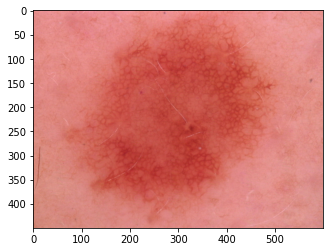

In [108]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Contrast limited adaptive histogram equalization (CLAHE)  to enhance the contrast of the images
This technique equalizes and expands the
image histogram while generating minimal noise.

In [109]:
def apply_clahe(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray_image)
    return clahe_image

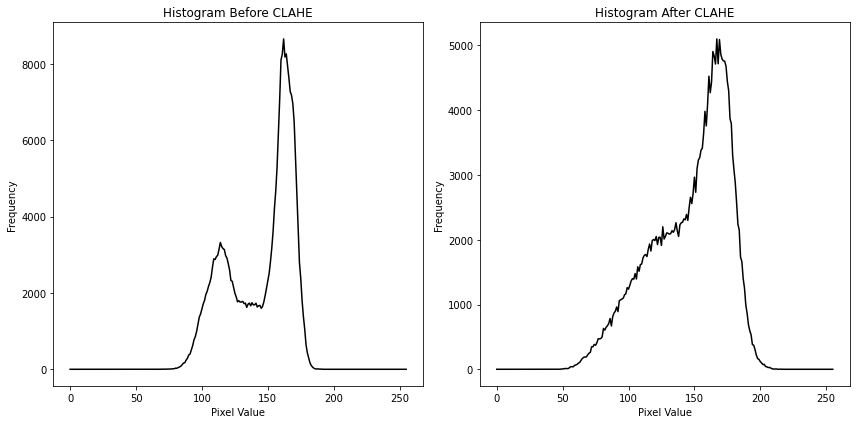

In [110]:
hist_before_clahe = cv2.calcHist([image_gray], [0], None, [256], [0, 256])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist_before_clahe, color='black')
plt.title('Histogram Before CLAHE')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

clahe_image = apply_clahe(image)

hist_after_clahe = cv2.calcHist([clahe_image], [0], None, [256], [0, 256])

plt.subplot(1, 2, 2)
plt.plot(hist_after_clahe, color='black')
plt.title('Histogram After CLAHE')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

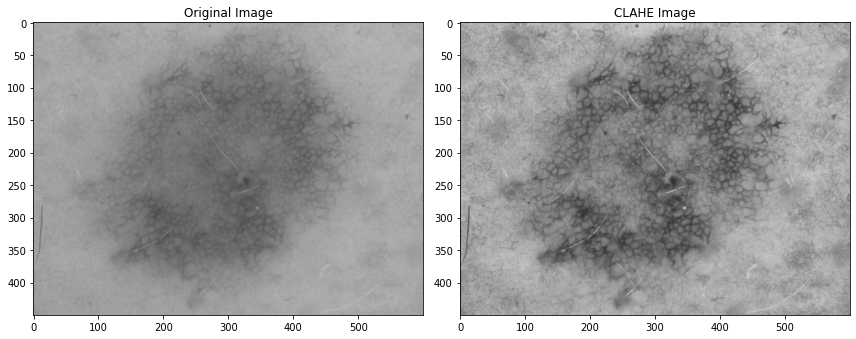

In [111]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_gray, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(clahe_image, cv2.COLOR_BGR2RGB))
plt.title('CLAHE Image')

plt.tight_layout()
plt.show()

### Gaussian filter to smoothe and reduce noise

In [112]:
def apply_gaussian_filter(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

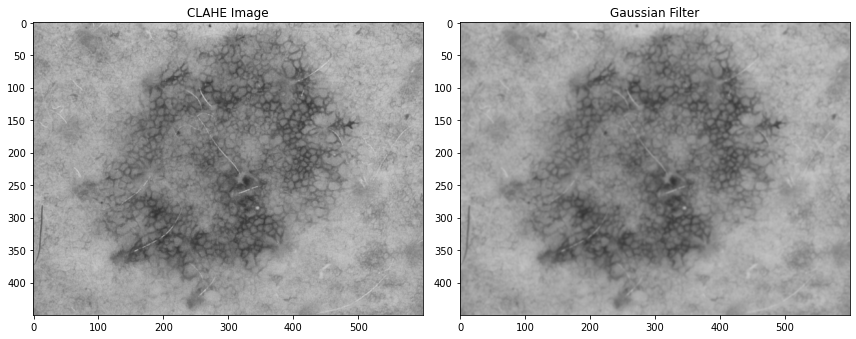

In [113]:
gaussian_filtered_image = apply_gaussian_filter(clahe_image)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(clahe_image, cv2.COLOR_BGR2RGB))
plt.title('CLAHE Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(gaussian_filtered_image, cv2.COLOR_BGR2RGB))
plt.title('Gaussian Filter')

plt.tight_layout()
plt.show()

### Alternative filter for the same use; Median Filter

In [114]:
def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

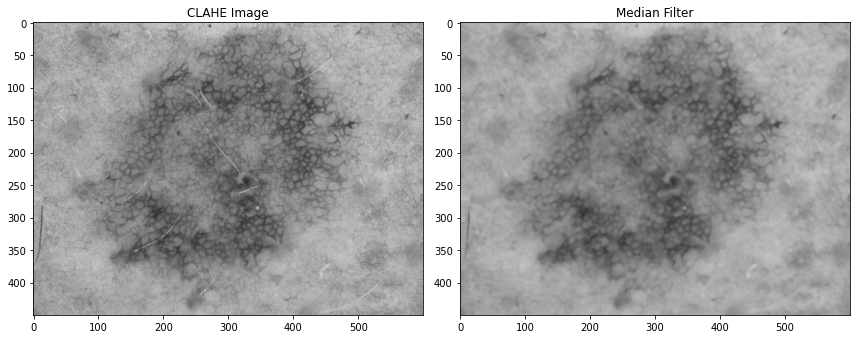

In [115]:
median_filtered_image = apply_median_filter(clahe_image)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(clahe_image, cv2.COLOR_BGR2RGB))
plt.title('CLAHE Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(median_filtered_image, cv2.COLOR_BGR2RGB))
plt.title('Median Filter')

plt.tight_layout()
plt.show()

We used the output of the Gaussian filter as it preserved the edges better than that of Median Filter

### 1.Segmentation of the lesion using K-means clustering
We used k=2 as the algorithm will cluster the image pixels into two groups which are skin and lesion
since these two are very distinct

In [116]:
def apply_kmeans(image, k=2):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    reshaped_image = image.reshape((-1, 3))
    reshaped_image = np.float32(reshaped_image)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(reshaped_image, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)

    segmented_image = centers[labels.flatten()]


    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image

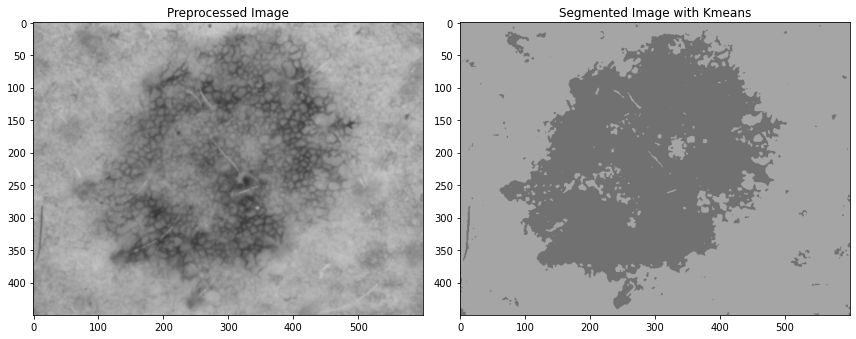

In [117]:
kmeans_segmented_image = apply_kmeans(gaussian_filtered_image)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(gaussian_filtered_image, cv2.COLOR_BGR2RGB))
plt.title('Preprocessed Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(kmeans_segmented_image, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image with Kmeans')

plt.tight_layout()
plt.show()

### 2.Canny edge detection 
Canny edge detector finds bold edges and then thinning them to have a one-pixel width. Having thin
edges is very useful because we want to separate as accurately as possible the lesion from the surrounding skin without losing pixel information in the process. Applying it on the original image gives very low accuracy as the edges are all over the images. Applying the Canny edge detector after using K-means usually gives a good result depending on the shape of the lesion.

In [118]:
def apply_canny(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, 30, 100)
    return edges

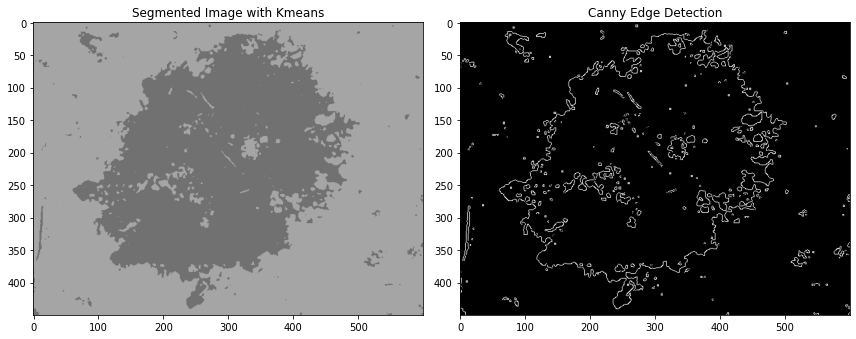

In [119]:
canny_edges = apply_canny(kmeans_segmented_image)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(kmeans_segmented_image, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image with Kmeans')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(canny_edges, cv2.COLOR_BGR2RGB))
plt.title('Canny Edge Detection')

plt.tight_layout()
plt.show()

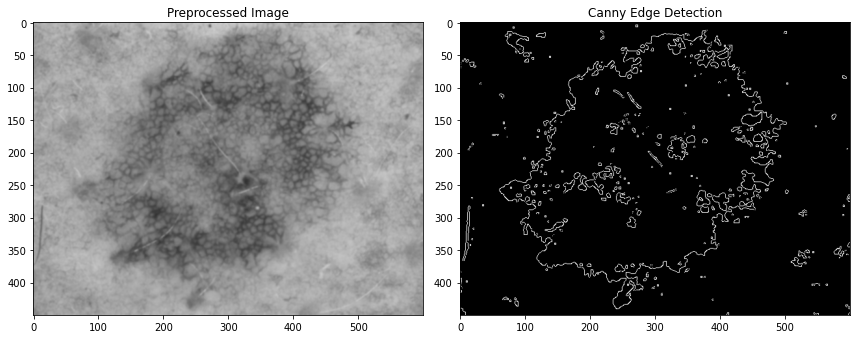

In [120]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(gaussian_filtered_image, cv2.COLOR_BGR2RGB))
plt.title('Preprocessed Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(canny_edges, cv2.COLOR_BGR2RGB))
plt.title('Canny Edge Detection')

plt.tight_layout()
plt.show()

### 3.Using adaptive mean thresholding to segment the lesion

In [121]:
def apply_adaptive_threshold(image):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return threshold_image

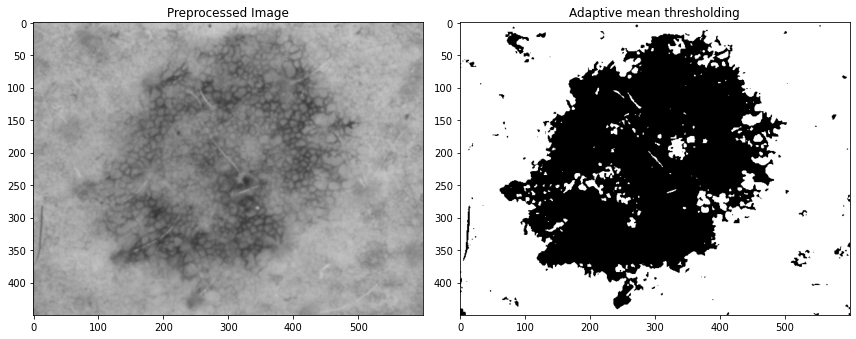

In [122]:
adaptive_threshold_image = apply_adaptive_threshold(gaussian_filtered_image)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(gaussian_filtered_image, cv2.COLOR_BGR2RGB))
plt.title('Preprocessed Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(adaptive_threshold_image, cv2.COLOR_BGR2RGB))
plt.title('Adaptive mean thresholding')

plt.tight_layout()
plt.show()

### Swapping the colors of the lesion and skin then remove isolated pixel

In [123]:
def swap_colors(image):
    swapped_image = cv2.bitwise_not(image)
    return swapped_image

def remove_isolated_pixels(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 500:
            cv2.drawContours(image, [contour], 0, 0, -1)

    return image

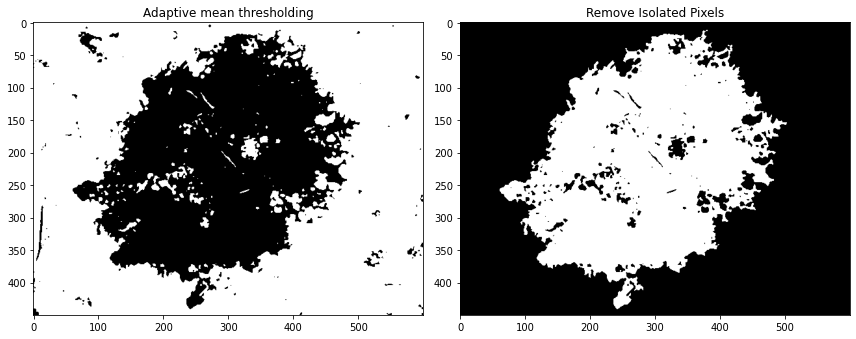

In [124]:
swapped_image = swap_colors(adaptive_threshold_image)
processed_image = remove_isolated_pixels(swapped_image)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(adaptive_threshold_image, cv2.COLOR_BGR2RGB))
plt.title('Adaptive mean thresholding')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
plt.title('Remove Isolated Pixels')

plt.tight_layout()
plt.show()

### Feature Extraction

In [125]:
def calculate_asymmetry(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    height, width = image.shape

    half_width = width // 2

    left_half = image[:, :half_width]
    right_half = image[:, half_width:]

    flipped_right_half = cv2.flip(right_half, 1)


    asymmetry_diff = cv2.absdiff(left_half, flipped_right_half)

    asymmetry_score = np.sum(asymmetry_diff)

    return asymmetry_score


def calculate_area_and_perimeter(image):
    edges = cv2.Canny(image, 30, 100)

    perimeter = np.sum(edges == 255)

    area = np.sum(image == 255)

    return area, perimeter


def calculate_circularity(area, perimeter):
    if perimeter == 0:
        return 0
    
    circularity = (4 * np.pi * area) / (perimeter ** 2)

    return circularity


def extract_number_of_colors(image_path):
    colors, _ = extract_from_path(image_path)
    return len(colors)


In [126]:
asymmetry_score = calculate_asymmetry(processed_image)
area, perimeter = calculate_area_and_perimeter(processed_image)
circularity = calculate_circularity(area, perimeter)
number_of_colors = extract_number_of_colors(image_path)

In [127]:
print("Asymmetry Score:", asymmetry_score)
print("Area:", area)
print("Perimeter:", perimeter)
print("Circularity:", circularity)
print("Number of Colors:", number_of_colors)

Asymmetry Score: 6137085
Area: 95065
Perimeter: 6164
Circularity: 0.03144164475286509
Number of Colors: 2


In [128]:
feature_vector = np.array([asymmetry_score, area, perimeter, circularity, number_of_colors]).reshape(1, -1)
scaled_feature_vector = scaler.transform(feature_vector)

prediction = knn_classifier.predict(scaled_feature_vector)
print(scaled_feature_vector)

if prediction == 1:
    print("The image is predicted as Melanoma.")
else:
    print("The image is predicted as Not Melanoma.")

[[ 0.34899041  1.52945308  0.86544091 -0.68997281 -0.9488067 ]]
The image is predicted as Not Melanoma.


c:\Users\Aya Abo Bakr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
